In [195]:
%matplotlib inline
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as pyplot
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from numpy import sort
import seaborn as sns
from sklearn.metrics import mean_squared_error
import math
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV,BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor
import lightgbm as lgb
from sklearn.svm import NuSVR, SVR, LinearSVR
from scipy import stats


In [196]:
# rmsle
def rmsle(y, y_pred):
    return mean_squared_error(y, y_pred)

In [197]:
def ohe(input_data, col, col_dict):
    x = input_data[col].fillna('NA')
    y = x.astype('category',categories=col_dict[col])
    return pd.get_dummies(y,prefix=col)
    

In [198]:
def filter_col_by_coor(X_train,y_train):
    y = np.abs(X_train.corrwith(y_train)).sort_values(ascending=False)
    y = y[y>0.02]
    X_train =  X_train[y.index]
    
    # Create correlation matrix
    corr_matrix = X_train.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
    
    cols_retain = []
    for col in list(X_train.columns.values):
        if col not in to_drop:
            cols_retain.append(col)
    
    return X_train[cols_retain]
    
    

In [229]:
def get_features(input_data,ohe_cols,sel_cols, ro, col_dict,cols=None):
    
    input_data['porch'] = input_data['3SsnPorch'] + input_data['WoodDeckSF'] + input_data['OpenPorchSF'] + input_data['EnclosedPorch'] + input_data['ScreenPorch']
    input_data['SF'] = input_data['1stFlrSF'] + input_data['2ndFlrSF'] + input_data['BsmtFinSF1'] + input_data['BsmtFinSF2'] + input_data['TotalBsmtSF']
    input_data['LowQualFinSFPercent'] = 100 - (input_data['LowQualFinSF']*100)/input_data['SF']
    input_data['baths'] = input_data['BsmtFullBath'] + input_data['BsmtHalfBath'] + input_data['FullBath'] + input_data['HalfBath']
    
    
    
    
    features = input_data[sel_cols]
    features['LotFrontage'] = input_data['LotFrontage'].fillna(input_data['LotArea']/140.0)
    
    
    features['SF'] = np.power(features['SF'],(1/4))
    features['LotFrontage'] = np.power(features['LotFrontage'],(1/4))
    features['GarageArea'] = np.power(features['GarageArea'],(1/10))
    features['LotArea'] = np.power(features['LotArea'],(1/4))
    features['GrLivArea'] = np.power(features['GrLivArea'],(1/4))
   
    features['MasVnrArea'] = input_data['MasVnrArea'].fillna(0)

    features=features.join(pd.DataFrame({'GarageYrBlt':input_data['GarageYrBlt']-input_data['GarageYrBlt'].min()}))
    features['GarageYrBlt'] = features['GarageYrBlt'].fillna(-1)   
    features=features.join(pd.DataFrame({'YrSold':input_data['YrSold']-input_data['YrSold'].min()}))
    features=features.join(pd.DataFrame({'YearRemodAdd':input_data['YearRemodAdd']-input_data['YearRemodAdd'].min()}))
    
    
    for col in ohe_cols:
        features=features.join(ohe(input_data,col,col_dict))
        
        
       
    cc = ['Artery','Feedr','Norm','RRNn','RRAn','PosN','PosA','RRNe','RRAe']
    for c in cc:
        features['Condition_'+c]= (input_data['Condition1']==c) & (input_data['Condition2']==c)
        features['Condition_'+c] = features['Condition_'+c].astype(int)
    
    cc = ['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NA']
    for c in cc:
        features['BsmtFinType'+c] = (input_data['BsmtFinType1']==c) & (input_data['BsmtFinType2']==c)
        features['BsmtFinType'+c] = features['BsmtFinType'+c].astype(int)
    
    cc = ['AsbShng','AsphShn','BrkComm','BrkFace','CBlock','CemntBd','HdBoard','ImStucc','MetalSd','Other','Plywood','PreCast','Stone','Stucco','VinylSd','WdShing']
    for c in cc:
        features['Exteriror'+c] = (input_data['Exterior1st']==c) & (input_data['Exterior2nd']==c)
        features['Exteriror'+c] = features['Exteriror'+c].astype(int)
    
    cols_to_delete=['CentralAir_N']
    for ctd in cols_to_delete:        
        features = features.drop(ctd,axis=1)
        
    if cols:
        features = features[cols]
    else:
        features = filter_col_by_coor(features,input_data["SalePrice"])
        
    na = features.isna().sum()
    na = na[na>0]
    print(na)
    
    features = features.fillna(0)
    
    if ro:    
        features['SalePrice'] = input_data['SalePrice']    
        print('Before ',features.shape)
        features = features[(np.abs(stats.zscore(features)) < 13).all(axis=1)]
        print('After ',features.shape)
    
    
    return features

    

In [230]:
def get_col_dict(input_data,cols):
    col_dict = {}
    for col in cols:
        x = input_data[col].fillna('NA')
        y = x.unique()
        col_dict[col] = y
    return col_dict
        

In [231]:
def model_test():
    ohe_cols = list(set(['MasVnrType','MiscFeature','LandContour','LotShape','Alley','Street','GarageFinish','GarageCond','SaleType','SaleCondition','GarageType','Functional','Electrical','BsmtExposure','BsmtCond','BsmtQual','ExterQual','MasVnrType','RoofStyle','HouseStyle','BldgType','Fence','HeatingQC','CentralAir','KitchenQual','FireplaceQu','GarageQual','PavedDrive','MSSubClass','MSZoning','LotConfig','Neighborhood']))
    scalar_cols = list(set(['GrLivArea','LotArea','GarageArea','LotFrontage','porch','TotRmsAbvGrd','BedroomAbvGr','baths','LowQualFinSFPercent','OverallQual','OverallCond','MasVnrArea','SF','Fireplaces','GarageCars']))
   
    input_data = pd.read_csv('train.csv')
    input_data=input_data[input_data['GrLivArea']<4000]

    col_dict = get_col_dict(input_data,ohe_cols)
    
    features = get_features(input_data,ohe_cols,scalar_cols,True, col_dict)
        
    features.to_csv('features.csv')
    
    target = np.log1p(features["SalePrice"])    
    
    features = features.drop(columns=['SalePrice'])

        
    '''Train model '''
    alphas_alt = [11.0,12.3, 12,14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5,15.6,15.7,15.8] 
    for i in range(100):
        alphas_alt.append(i)
    kfolds = KFold(n_splits=4, shuffle=True, random_state=66)
    
    
    ridge = make_pipeline(TransformedTargetRegressor(regressor=RidgeCV(alphas=alphas_alt, cv=kfolds),transformer=QuantileTransformer(output_distribution='normal')))
    ridge = make_pipeline(RobustScaler(),RidgeCV(alphas=alphas_alt, cv=kfolds))
    
    
    ridge.fit(features,target)

    print(rmsle(target,ridge.predict(features)))
    plt.figure(figsize=(15,10))
    plt.scatter(np.expm1(target), np.expm1(ridge.predict(features)))
    
    '''
    scaler = RobustScaler()
    scaler.fit(features)
    features_scaled = scaler.transform(features)
    
    ridge = MLPRegressor(hidden_layer_sizes=5000)
    ridge.fit(features_scaled,target)
  
    target_predicted = ridge.predict(features_scaled)
    print(rmsle(np.expm1(target),np.expm1(target_predicted)))
    '''
    return (ridge,ohe_cols,scalar_cols,col_dict,list(features.columns.values))

    

/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Series([], dtype: int64)
Before  (1456, 192)
After  (1380, 192)
0.009438391134804951


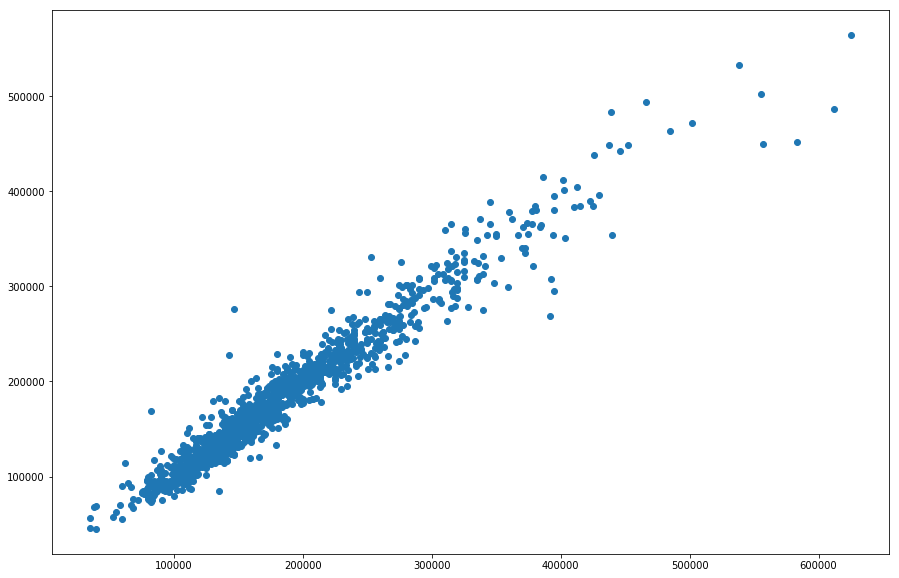

In [235]:
clf,ohe_cols,scalar_cols,col_dict,cols = model_test()

In [233]:
def predict_result(clf,ohe_cols,scalar_cols, col_dict):
    test_data = pd.read_csv('test.csv')
    test_features = get_features(test_data,ohe_cols,scalar_cols, False,col_dict,cols)
    print('Test features shape ',test_features.shape)
    p_values = np.floor(np.expm1(clf.predict(test_features)))
    predicted_values = test_data[['Id']]
    predicted_values=predicted_values.join(pd.DataFrame({'SalePrice':p_values}))
    predicted_values.to_csv('Predicted_Values.csv', index=False)

In [234]:
predict_result(clf,ohe_cols,scalar_cols, col_dict)

/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

SF                     1
GarageCars             1
baths                  2
GarageArea             1
LowQualFinSFPercent    1
dtype: int64
Test features shape  (1459, 191)


/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  This is separate from the ipykernel package so we can avoid doing imports until


Y    1365
N      95
Name: CentralAir, dtype: int64


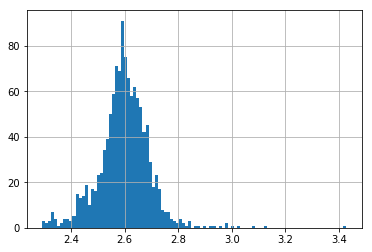

In [42]:
input_data = pd.read_csv('train.csv')

'''input_data['SaleCondition'].fillna('NA').value_counts().plot(kind='bar')'''
input_data['SF'] = input_data['1stFlrSF'] + input_data['2ndFlrSF'] + input_data['BsmtFinSF1'] + input_data['BsmtFinSF2'] + input_data['TotalBsmtSF']
input_data['SF'] += input_data['LotFrontage'] + input_data['GarageArea']+input_data['LotArea'] + input_data['GrLivArea']
x = np.power(input_data['SF'],(1/10))
s = input_data['CentralAir'].value_counts()
print(s)
x.hist(bins=100)






In [43]:
ft = pd.read_csv('features.csv')

for col in ft.columns:
    s = ft[col].value_counts()
    print(s)


1459    1
477     1
479     1
480     1
481     1
482     1
483     1
484     1
485     1
486     1
487     1
488     1
489     1
490     1
491     1
492     1
493     1
494     1
495     1
496     1
497     1
478     1
476     1
499     1
475     1
456     1
457     1
458     1
459     1
460     1
       ..
994     1
995     1
996     1
997     1
998     1
999     1
1000    1
981     1
980     1
979     1
968     1
960     1
961     1
962     1
963     1
964     1
965     1
966     1
967     1
969     1
978     1
970     1
971     1
972     1
973     1
974     1
975     1
976     1
977     1
0       1
Name: Unnamed: 0, Length: 1456, dtype: int64
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     14
2       3
1       2
Name: OverallQual, dtype: int64
6.947937    7
7.914618    6
7.689371    6
7.765993    6
7.832411    5
7.489412    4
7.893572    4
7.544861    4
8.061171    4
7.711101    4
8.033658    4
7.921898    4
7.820440    4
8.017967    4
7.855932    3
7.8

Name: LandContour_Lvl, dtype: int64
0    1455
1       1
Name: Condition_Feedr, dtype: int64
0    1455
1       1
Name: HeatingQC_Po, dtype: int64
0    1432
1      24
Name: ExterirorBrkFace, dtype: int64
0    1437
1      19
Name: GarageType_Basment, dtype: int64
0    1455
1       1
Name: ExterirorImStucc, dtype: int64
0    1451
1       5
Name: SaleType_ConLw, dtype: int64
0    1398
1      58
Name: MSSubClass_80, dtype: int64
0    1455
1       1
Name: ExterirorAsphShn, dtype: int64
0    1454
1       2
Name: GarageCond_Ex, dtype: int64
0    1415
1      41
Name: Alley_Pave, dtype: int64
0    1383
1      73
Name: Neighborhood_NWAmes, dtype: int64
0    1445
1      11
Name: HouseStyle_2.5Unf, dtype: int64
0    1455
1       1
Name: ExterirorCBlock, dtype: int64
0    1423
1      33
Name: FireplaceQu_Fa, dtype: int64
0    1450
1       6
Name: GarageType_2Types, dtype: int64
0    1455
1       1
Name: MiscFeature_TenC, dtype: int64
3    338
1    326
0    314
2    303
4    175
Name: YrSold, dtype: i